# Numerical simulation for `Double-bracket quantum algorithms for quantum imaginary-time evolution`

### View paper at

https://arxiv.org/abs/2412.04554

### Contact https://mathstodon.xyz/@Marekgluza/113621100092525571

## Contents

1. [Initialization](#Initialization)<br>
     1.1 [Define the input Hamiltonian](#1.1-Define-the-input-Hamiltonian)    
     1.2 [Choose initial state](#1.2-Choose-initial-state)<br>
     1.3 [Implement GCI](#1.3-Implement-GCI)<br>
2. [Run ITE](#2.-Run-ITE)<br>
3. [Run QITE](#3.-Run-QITE)<br>
    
    3.2 [Run QITE DBI](#3.2-Run-QITE-DBI)<br>
    3.3. [Run QITE RGCI with perfect reflections](#3.3-Run-QITE-DBQA-RGCI-with-perfect-reflections)<br>
    3.4. [Run QITE RGCI with approxmate reflections](#3.4-Run-QITE-DBQA-RGCI-with-approximate-reflections)<br>
    3.5 [Run QITE DBQA RHOPF with perfect reflections](#3.5-Run-QITE-DBQA-RHOPF-with-perfect-reflections)<br>
        3.5.1 [Theoretical background of higher-order group-commutators](#3.5.1-Theoretical-background-of-higher-order-group-commutators)<br>
    3.6 [Run QITE DBQA RHOPF with approximate reflections](#3.6-Run-QITE-DBQA-RHOPF-with-approximate-reflections)
4. [Circuit depth analysis](#4.-Circuit-depth-analysis)<br>
4.1 [Counting CZ gates in Qibo](#4.1-Counting-CZ-gates-in-Qibo)<br>
4.2 [Visualization of CZ gate cost](#4.2-Visualization-of-CZ-gate-cost)

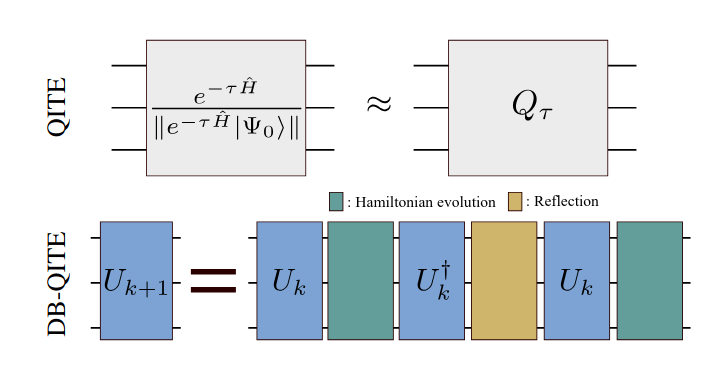

# 1. Initialization

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt


from hyperopt import hp, tpe
from scipy.linalg import expm
import qibo
from qibo import hamiltonians, set_backend, Circuit, symbols
from qibo.gates import Unitary
from qibo.symbols import *
set_backend("numpy")

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[Qibo 0.2.14|INFO|2024-12-10 21:42:05]: Using numpy backend on /CPU:0


## 1.1 Define the input Hamiltonian

[top](#Contents) 


In [2]:
L = 8
H_def = sum([ Z(x)*Z(x+1) +X(x)*X(x+1) +Y(x)*Y(x+1)  for x in range(L-1)])

H_sh = hamiltonians.SymbolicHamiltonian(H_def)
H = H_sh.matrix
H_sh.form

[Qibo 0.2.14|WARNING|2024-12-10 21:42:06]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


X0*X1 + X1*X2 + X2*X3 + X3*X4 + X4*X5 + X5*X6 + X6*X7 + Y0*Y1 + Y1*Y2 + Y2*Y3 + Y3*Y4 + Y4*Y5 + Y5*Y6 + Y6*Y7 + Z0*Z1 + Z1*Z2 + Z2*Z3 + Z3*Z4 + Z4*Z5 + Z5*Z6 + Z6*Z7

In [3]:
eigs = H_sh.eigenvalues()
target_energy = min(eigs)
print(target_energy)

-13.499730394751566


## 1.2 Choose initial state
[top](#Contents)
We will denote it by $|\psi_0\rangle$

In [4]:
def select_initial_state( init_type = None ):
    if init_type == "minimize over products":
        es_ini = []
        for i in range(2**L):
            psi0 = np.zeros([1,2**L]).T
            psi0[i] = 1
            es_ini.append(H_sh.expectation(psi0.T[0]))
        min(es_ini)
        psi0 = np.zeros([1,2**L]).T
        psi0[np.argmin(es_ini)] = 1
        PSI0 = psi0 @ psi0.conj().T
        return psi0 , PSI0
    if init_type == "all ones" or init_type is None:
        psi0 = np.zeros([1,2**L]).T
        psi0[-1] = 1
        PSI0 = psi0 @ psi0.conj().T
        return psi0 , PSI0
    if init_type == "all zeros" or init_type is None:
        psi0 = np.zeros([1,2**L]).T
        psi0[0] = 1
        PSI0 = psi0 @ psi0.conj().T
        return psi0 , PSI0
psi0, PSI = select_initial_state("minimize over products") 

In [5]:
def compute_moments( psi):
    if isinstance(psi, qibo.Circuit):
        return H_sh.expectation(psi(psi0.T[0]).state()), None, None
    E = (psi.conj().T @ H @ psi)[0,0].real
    S = (psi.conj().T @ H @ H @ psi)[0,0].real
    return E, S, S - E**2

In [6]:
compute_moments(psi0)

(-7.0, 77.0, 28.0)

## 1.3 Implement GCI
Here we take an approach of  passing the iterating variables and the appropriate step function handle.

[top](#Contents)

In [7]:
def GCI( gci_step, state_of_recursion, nmb_steps, times_dbr, please_be_verbose = True):
    """
    gci_step: takes in state and time and returns state out; the state can be either a pure state or `qibo.Circuit` (to extend to other types overload `compute_moments`)
    """
    results = []
    
    s_mins = [0]
    results.append(compute_moments(state_of_recursion))
    
    if isinstance(state_of_recursion, qibo.Circuit):
        circuit_depths = [0]
        circuits = [state_of_recursion]

    if nmb_steps is None:
        #run GCI for times prescribed in times_dbr
        for s in times_dbr:
            state_of_recursion = gci_step(state_of_recursion, s)
            results.append(compute_moments(state_of_recursion))
        s_mins = [0] + times_dbr
    else:
        #run GCI for nmb_steps with the best generator on the times_dbr grid
        for k in range(nmb_steps):

            test_es = [ compute_moments(gci_step(state_of_recursion,dt))[0] for dt in times_dbr ]
            
            ind = np.argmin(test_es)
            if ind == 0 or ind == len(times_dbr):
                print( k, ind, times_dbr[ind], "--- Warning edge of interval reached")
                
            s_min = times_dbr[ind]
            state_of_recursion = gci_step(state_of_recursion, s_min)

            results.append(compute_moments(state_of_recursion))
            s_mins.append(s_min)
            if isinstance(state_of_recursion, qibo.Circuit):
                circuit_depths.append(len(state_of_recursion.queue)*3)
                circuits.append(state_of_recursion)
                
    energies = [ r[0] for r in results ]
    variances = [ r[1] for r in results ]
    if not hasattr(gci_step, 'exponent'):
        gci_step.exponent = 2
    if not hasattr(gci_step, 'label'):
        gci_step.label = ''
    if not hasattr(gci_step, 'marker'):
        gci_step.marker = '-'
    return (
            energies, s_mins, variances, 
            [ sum(s**gci_step.exponent for s in s_mins[1:x])  for x in range(1,len(s_mins)+1)]if gci_step.exponent > 0 else s_mins,
            gci_step.label, gci_step.marker, 
        circuit_depths if isinstance(state_of_recursion, qibo.Circuit) else None, 
        circuits if isinstance(state_of_recursion, qibo.Circuit) else None
    )
            

def plot_GCI_results(*results, save_path = None):
    import matplotlib.pyplot as plt

    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['font.size'] = 12
    plt.rcParams['savefig.dpi'] = 75
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['legend.labelspacing'] = .3
    plt.rcParams['legend.columnspacing']= .3
    plt.rcParams['legend.handletextpad']= .1
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = "serif"
    plt.rcParams['font.serif'] = "cm"
    plt.rcParams["figure.figsize"] = [5, 3.50]
    plt.rcParams["figure.autolayout"] = True

    for result in results:
        if result[5] == '-':
            plt.plot(result[3], result[0], label=result[4], linestyle = result[5])        
        else:
            plt.plot(result[3], result[0], label=result[4], marker = result[5])


    plt.ylabel('Energy')
    plt.xlabel('Evolution duration')
    y_labels_rounded = [ round(y, 1 ) for y in [results[0][0][0],
                                                results[0][0][-1] ,
                                                (results[0][0][-1]+results[0][0][0])/2,
                                                ((results[0][0][-1]+results[0][0][0])/2+results[0][0][-1])/2,
                                                ((results[0][0][-1]+results[0][0][0])/2+results[0][0][0])/2
                       ] ]
    plt.grid()
    plt.yticks(y_labels_rounded)
    plt.legend(bbox_to_anchor=(1,1))
    plt.axline(  (0, target_energy), ( results[0][3][-1],target_energy), linestyle = ":" )
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# 2. Run ITE
[top](#Contents)

Imaginary-time evolution is defined by normalizing the action of a non-unitary propagator

$$|\Psi(\tau) \rangle = \frac{e^{-\tau \hat H} |\Psi_0\rangle}  {\| {e^{-\tau \hat H}}|\Psi_0\rangle \| }$$

In [8]:
def ITE_step(psi0, tau):    
    ITE_step.exponent = -1 #in order to use GCI, DBI is an exception in the scaling of the exponent of the DBR duration
    ITE_step.label=r"$ |{\Psi(\tau)}\rangle$"
    ITE_step.marker = '-'

    psi_tau = expm(- tau*H).dot(psi0)
    psi_tau = psi_tau / np.linalg.norm(psi_tau)
    return psi_tau


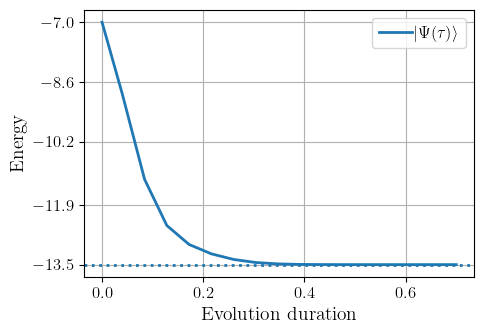

In [9]:
times_ITE = np.linspace(0.04,.7,16).tolist()
results_ITE = GCI(ITE_step,psi0, None, times_ITE)
plot_GCI_results(results_ITE)

In [10]:
energies_ITE = results_ITE[0]
energies_ITE[-1]

-13.49973037335853

In [11]:
target_energy

-13.499730394751566

# 3. Run QITE 

## 3.2 Run QITE DBI

Using casting of the Hamiltonian to its dense form we define the `QITE_DBI_step` by using `scipy.linalg.expm` as for [ITE](#1.-Run-ITE)

[top](#Contents)

In [12]:
def QITE_DBI_step(psi, s):
    QITE_DBI_step.exponent = 1 #in order to use GCI, DBI is an exception in the scaling of the exponent of the DBR duration
    QITE_DBI_step.label=r"$ |{\sigma_k}\rangle$"
    QITE_DBI_step.marker = 'o'
    
    PSI = psi@psi.T.conj()
    return expm(s *(PSI@H - H @PSI) )@ psi

results_DBI = GCI( QITE_DBI_step, psi0, 7, np.linspace(.01,.3,10) )   
    

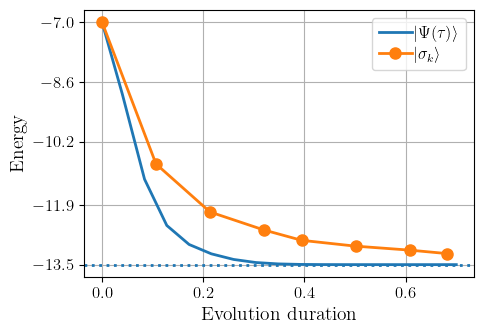

In [13]:
plot_GCI_results(results_ITE,results_DBI)

In [14]:
results_DBI[0][-1]

-13.204599737642633

In [15]:
target_energy

-13.499730394751566

## 3.3 Run QITE DBQA RGCI with perfect reflections

$$ |{\omega_{k+1}} \rangle= e^{i\sqrt{s_k}H} e^{i\sqrt{s_k}\omega_k}   
    e^{-i\sqrt{s_k}H}|{\omega_k}\rangle$$

where $\omega_k = |\omega_k\rangle\langle \omega_k|$

[top](#Contents)

In [16]:
def QITE_RGCI_step(psi, s):
    QITE_RGCI_step.label=r"$ |{\omega_k}\rangle$"
    QITE_RGCI_step.marker = 'x'
    
    PSI = psi@psi.T.conj()
    U_t = expm(1j*s *H )
    return U_t @ expm(1j *s * PSI) @ U_t.conj().T @ psi


results_RGCI = GCI( QITE_RGCI_step, psi0, 10, np.linspace(.1,.3,10) )   

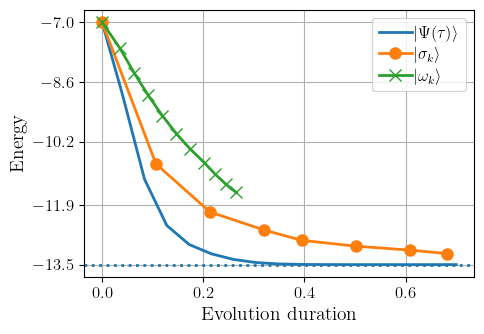

In [17]:
plot_GCI_results(results_ITE,results_DBI,results_RGCI)

## 3.4 Run QITE DBQA RGCI with approximate reflections


Notice that
$|{0}\rangle\langle{0}|= \prod_{i=1}^L(1+Z_i)/2 = 2^{-L} +2^{-L}\sum_{i=1}^L Z_i + 2^{-L}\sum_{i,j=1}^LZ_iZ_j+\ldots$
and so we will consider in numerics

$$|{\omega_{k+1}'} \rangle= e^{i\sqrt{s_k}H} e^{i\sqrt{s_k}H_Z}   
    e^{-i\sqrt{s_k}H}|{\omega_k'}\rangle $$

with $H_Z=\sum_{i=1}^L Z_i + \sum_{i,j=1}^LZ_iZ_j$.

[top](#Contents)

In [18]:
HZZ_sh = hamiltonians.SymbolicHamiltonian(sum([Z(x) for x in range(L)] +[Z(x)*Z(x+1) for x in range(L-1)]))
def QITE_RGCI_ZZ_step(U, s):
    QITE_RGCI_ZZ_step.label=r"$ |{\omega_k}'\rangle$"
    QITE_RGCI_ZZ_step.marker = '.'
    d= HZZ_sh.circuit(-s)
    h = H_sh.circuit(s)
    h2 = h.invert()

    V = h2 + U.invert() +  d + U + h
    return U + V 
        
results_RGCI_ZZ = GCI( QITE_RGCI_ZZ_step, Circuit(L), 6, np.linspace(.01,.1,10) )   

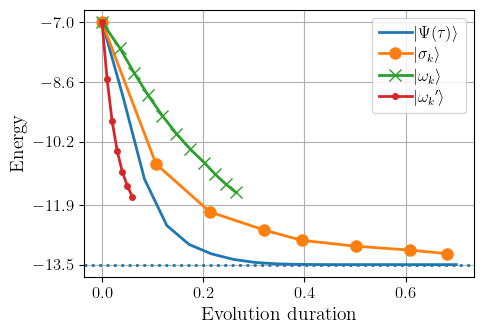

In [19]:
plot_GCI_results(results_ITE,results_DBI,results_RGCI,results_RGCI_ZZ)        

## 3.5 Run QITE DBQA RHOPF with perfect reflections

### 3.5.1 Theoretical background of higher-order group-commutators


The following formula is given in Eq. (8) of [Chen et al PRR 2022](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.013191)
\begin{align}
	V^{\text{(HOPF)}}(A,B) = 
	e^{ i \phi A}
	e^{i \phi B}
	e^{-i A}
	e^{-i(\phi+1) B}
	e^{i (1-\phi) A}
	e^{iB}\ 
\end{align}
with $\phi = \frac  12 (\sqrt 5 -1)$.

This is designed to approximate a double-bracket rotation 
$$V^{\text{(HOPF)}}(A,B)\approx e^{-[A,B]} $$
To use it for a group commutator iteration we can set
\begin{align}
	V_k = V^{\text{(HOPF)}}(\sqrt{s_k}H,\sqrt{s_k}\omega_k)  = e^{s_k[\omega_k,H]} + O(s_k^2)\ 
\end{align}

W will be applying $V_k|\omega_k\rangle$ so we drop the phase coming from the last unitary
\begin{align}
	V^{\text{(RHOPF)}}(A,B) = 
	e^{ i \phi A}
	e^{i \phi B}
	e^{-i A}
	e^{-i(\phi+1) B}
	e^{i (1-\phi) A}\ .
\end{align}
And use 
\begin{align}
	V_k = V^{\text{(RHOPF)}}(\sqrt{s_k}H,\sqrt{s_k}\omega_k)  = e^{s_k[\omega_k,H]}  + O(s_k^2)\ .
\end{align}
to define the QITE RHOPF GCI DBQA state while benefiting from 1 less query to reflections around the input state.

To clarify, we broadly speak of QITE DBQA anytime we find a synthesis in terms of products of unitaries such that the QITE DBI is approximated in every step.
Here we refer to RGCI as the reduced form of the group commutator and RHOPF is the reduced higher-order product formula.


[top](#Contents)

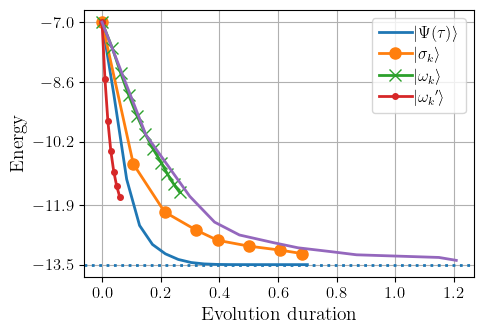

In [20]:
def QITE_RHOPF_step(psi, s): 
    phi = 0.5*(np.sqrt(5)-1)

   # Default: exact diagonalization
    U_t = expm(1j* s *H )
    U_t_phi = expm(1j* s *phi*H )
    PSI = psi@psi.T.conj()
    PSI_t = expm(1j * s * PSI)
    PSI_t_phi = expm(1j * s * phi * PSI)
    return U_t_phi @ PSI_t_phi @ U_t.conj().T @ PSI_t_phi.conj().T @PSI_t.conj().T @ U_t @ U_t_phi.conj().T @ psi





results_RHOPF_ED = GCI( QITE_RHOPF_step, psi0, 10, np.linspace(.1,.53,10)  )
    
plot_GCI_results(results_ITE,results_DBI,results_RGCI,results_RGCI_ZZ,results_RHOPF_ED)

## 3.6 Run QITE DBQA RHOPF with approximate reflections



[top](#Contents)

In [21]:
def QITE_RHOPF_ZZ(circ, s, return_gate_count = None, warmstart_count_CZ = 0, H_mode_circuit = True):   
    QITE_RHOPF_ZZ.label=r"$ |{\omega_k}''\rangle$"
    QITE_RHOPF_ZZ.marker = 'd'
    phi = 0.5*(np.sqrt(5)-1)
     
    c_t1 = H_sh.circuit(-s*phi) #expm(1j* s *phi*H )
    c_t2 = H_sh.circuit(s)
    c_t3 = H_sh.circuit(s*(phi-1))
    HZZ_sh = hamiltonians.SymbolicHamiltonian(sum([Z(x) for x in range(L)] +[Z(x)*Z(x+1) for x in range(L-1)]))

    PSI_t1 = HZZ_sh.circuit(s* phi)
    PSI_t2 = HZZ_sh.circuit(-s*(1+phi))

    return circ+ c_t3 + circ.invert() + PSI_t2 + circ + c_t2 + circ.invert() + PSI_t1 + circ + c_t1 

results_RHOPF_ZZ = GCI( QITE_RHOPF_ZZ, Circuit(L), 5, np.linspace(0.01,0.3,10))

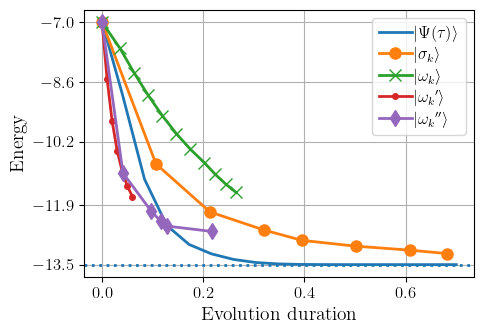

In [22]:
plot_GCI_results(results_ITE,results_DBI,results_RGCI,results_RGCI_ZZ,results_RHOPF_ZZ, save_path="Fig_1.pdf")

# 4. Circuit depth analysis

[top](#Contents)

## 4.1 Counting CZ gates in Qibo

[top](#Contents)

The final circuit of RGCI was

In [23]:
U = results_RGCI_ZZ[-1][-1]

has length

In [24]:
len(U.queue)

15288

which is

In [25]:
int(len(U.queue)/L)

1911

2-qubit gates per qubit. This has been stored as

In [26]:
results_RGCI_ZZ[-1]

In [27]:
results_RGCI_ZZ[-2][-1]

45864

which accounts for the number of CZ gates

In [28]:
len(U.queue)*3

45864

To see why this multiplication by 3 is done, consider the following.

The circuit consits only of gates which pertain to at least

In [29]:
print(min([len(g.qubits) for g in U.queue]))

2


qubits and maximally

In [30]:
print(max([len(g.qubits) for g in U.queue]))

2


qubits so there we double-checked that there are only 2 qubit gates (this follows from the symbolic definition of the Hamiltonian above which contains only two qubit terms; `qibo.Hamiltonians.SymbolicHamiltonian.circuit` performs 2nd order Trotter-Suzuki decomposition so will produce circuits with 2-qubit gates). Using the Vatan-Williams decomposition (every 2 qubit gate can be implemented with 3 CZ gates) this means that the circuit can be compiled with

In [31]:
int(3*len(U.queue)/L)

5733

CZ gates per qubit.

## 4.2 Visualization of CZ gate cost

[top](#Contents)

In [32]:
depths_RGCI = results_RGCI_ZZ[-2]
energies_RGCI = results_RGCI_ZZ[0]

depths_RHOPF = results_RHOPF_ZZ[-2]
energies_RHOPF = results_RHOPF_ZZ[0]

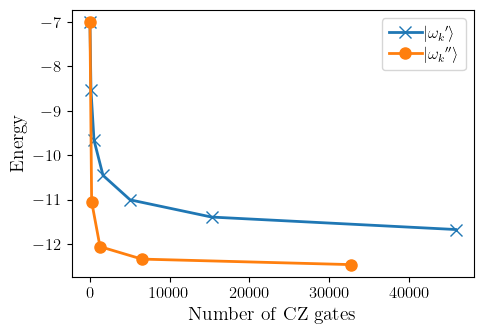

In [33]:
plt.plot(depths_RGCI, energies_RGCI, '-x',label=r"$ |{\omega_k}'\rangle$")
plt.plot(depths_RHOPF[:-1], energies_RHOPF[:-1], '-o',label=r"$ |{\omega_k}''\rangle$")
plt.xlabel('Number of CZ gates ')
plt.ylabel('Energy ')
plt.legend()

plt.savefig('Fig_depth.pdf')

In [34]:
4**L

65536